# RESUMO

# IMPORTANDO BIBLIOTECAS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
import math
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import PowerTransformer
from scipy.stats import skew, boxcox, yeojohnson
from scipy.special import inv_boxcox

import warnings
warnings.filterwarnings('ignore')

from lightgbm import LGBMRegressor

tqdm.pandas()


c:\Users\VitorAquino\anaconda3\envs\renner\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**LINK DEMONSTRANDO AS COMPARAÇÕES** <br>
https://towardsdatascience.com/types-of-transformations-for-better-normal-distribution-61c22668d3b9


# CARREGANDO DADOS

In [2]:
df_train = pd.read_csv('dados/train.csv')
df_test = pd.read_csv('dados/test.csv')
df_submission = pd.read_csv('dados/sample_submission.csv')

# Distribuição da variável target

In [3]:
target_testes = df_train[['yield']]

## SEM TRANSFORMAÇÃO

<Figure size 2000x800 with 0 Axes>

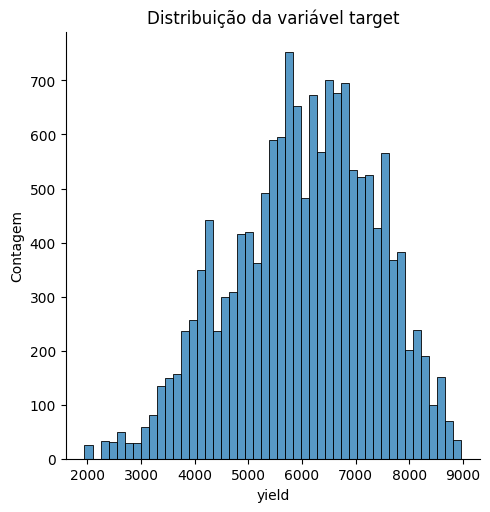

In [4]:
plt.figure(figsize=(20,8))
sns.displot(target_testes, x="yield")
plt.title('Distribuição da variável target')
plt.ylabel('Contagem')
plt.show()

In [5]:
target_testes['yield'].kurtosis()

-0.436563864726061

In [6]:
target_testes['yield'].skew()

-0.29119496049488897

## BOX-COX 
VALORES ESTRITAMENTE POSITIVOS

In [7]:
target_testes['boxcox_yield'], _ = boxcox(target_testes["yield"])

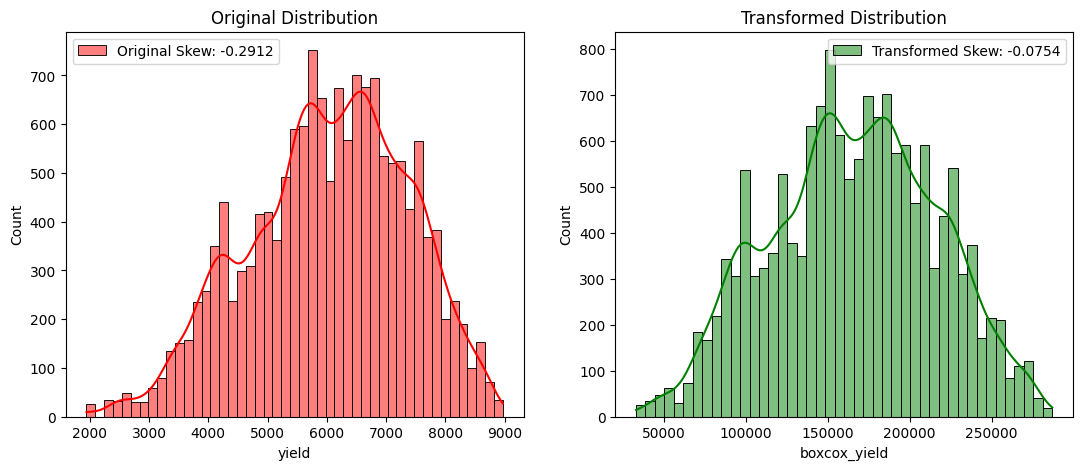

In [8]:
# Configurar o tamanho da figura
plt.rcParams["figure.figsize"] = 13, 5

# Plotar as distribuições antes e depois da transformação
fig, ax = plt.subplots(1, 2)
sns.histplot(target_testes["yield"], kde=True, color="r", label="Original Skew: {0}".format(np.round(target_testes["yield"].skew(), 4)), ax=ax[0])
sns.histplot(target_testes['boxcox_yield'], kde=True, color="g", label="Transformed Skew: {0}".format(np.round(target_testes['boxcox_yield'].skew(), 4)), ax=ax[1])

# Adicionar legendas e títulos aos gráficos
ax[0].legend()
ax[0].set_title("Original Distribution")
ax[1].legend()
ax[1].set_title("Transformed Distribution")

plt.show()

# MODELOS

In [9]:

from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

In [10]:
lista_modelo_utilizado = []
lista_transformacao_utilizado = []
# lista_num_features = []
lista_MAE = []

## OLS

###  SEM TRANSFORMAÇÃO

Média dos scores de MAE: 372.57083033800353
Desvio padrão dos scores de MAE: 5.584087307749434


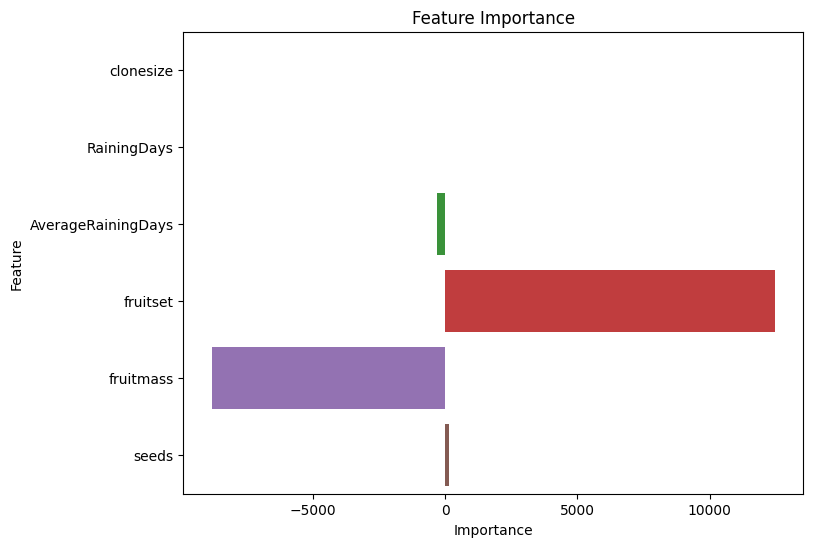

In [11]:
X = df_train[['clonesize', 'RainingDays', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds']]
y = df_train[['yield']]


kf = KFold(n_splits=5, shuffle=True, random_state=10)
MAE_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    OLS = LinearRegression()
    OLS = OLS.fit(X_train, y_train)
    y_pred = OLS.predict(X_test).squeeze().tolist()

    MAE = mean_absolute_error(y_true=y_test, y_pred=y_pred)
    MAE_scores.append(MAE)


# Exibir a média e o desvio padrão dos scores de MAE
print(f'Média dos scores de MAE: {np.mean(MAE_scores)}')
print(f'Desvio padrão dos scores de MAE: {np.std(MAE_scores)}')

# Coeficientes do modelo (feature importance) e nomes das features
feature_importance = OLS.coef_[0]
feature_names = X.columns  # Substitua pelos nomes reais das suas features

# Criar um DataFrame para facilitar a plotagem
df_importance = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Plotar a importância dos recursos
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=df_importance, orient='h')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

lista_modelo_utilizado.append('OLS')
lista_transformacao_utilizado.append('SEM TRANSFORMAÇÃO')
#lista_num_features.append(len(feature_names))
lista_MAE.append(np.mean(MAE_scores))

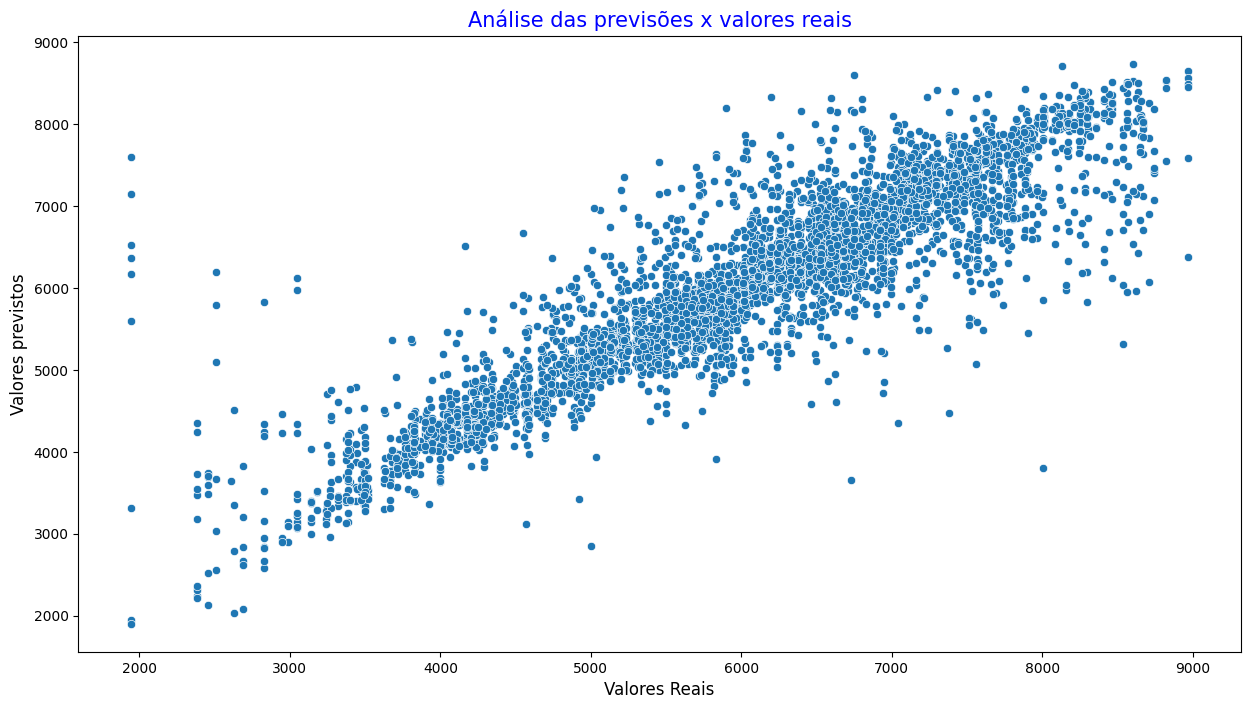

O ERRO OBTIDO PARA ESSA MODELAGEM: 367.58564135658804


In [12]:
X = df_train[['clonesize', 'RainingDays', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds']]
y = df_train[['yield']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)


OLS = LinearRegression()
OLS = OLS.fit(X_train, y_train)
y_pred = OLS.predict(X_test).squeeze().tolist()



plt.figure(figsize=(15,8))
sns.scatterplot(x=y_test['yield'], y=y_pred)
plt.title('Análise das previsões x valores reais', fontsize=15, color='blue')
plt.xlabel('Valores Reais', fontsize=12)
plt.ylabel('Valores previstos', fontsize=12)
plt.show()

MAE = mean_absolute_error(y_true=y_test['yield'], y_pred=y_pred)
print(f'O ERRO OBTIDO PARA ESSA MODELAGEM: {MAE}')

### BOX-COX

Média dos scores de MAE: 379.2537963888677
Desvio padrão dos scores de MAE: 5.886854252048312


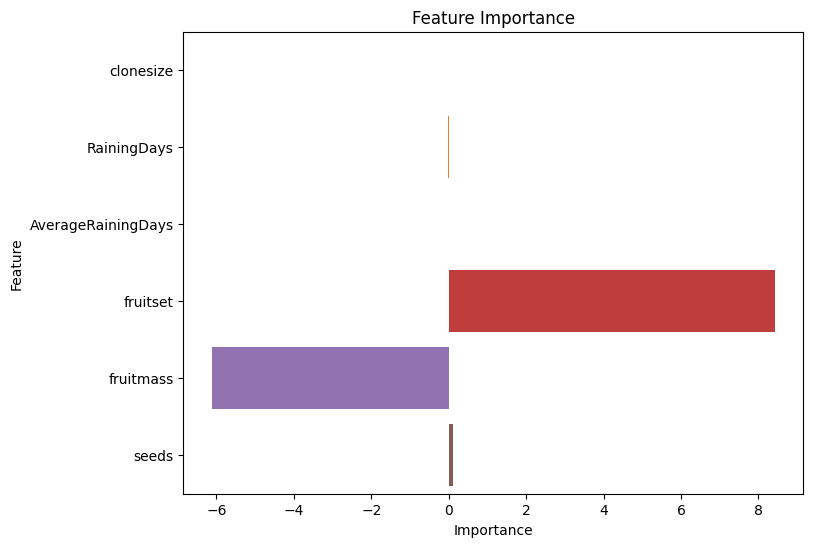

In [13]:
X = df_train[['clonesize', 'RainingDays', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds']]
y = df_train[['yield']]


# Transformação de Box Cox
boxcox_transformer = PowerTransformer(method='box-cox')
# Reshape y para uma matriz bidimensional
y_reshaped = np.array(y['yield']).reshape(-1, 1)

y_boxcox = boxcox_transformer.fit_transform(y_reshaped)

y['yield'] = y_boxcox.flatten()

kf = KFold(n_splits=5, shuffle=True, random_state=10)
MAE_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    OLS = LinearRegression()
    OLS = OLS.fit(X_train, y_train)
    y_pred = OLS.predict(X_test).squeeze().tolist()

    # Convertendo listas para arrays NumPy
    y_pred = np.array(y_pred)
    y_test = np.array(y_test)

    # Remodelar para uma matriz bidimensional
    y_pred = y_pred.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    y_pred_corrigido = boxcox_transformer.inverse_transform(y_pred)
    y_pred_corrigido = y_pred_corrigido.squeeze().tolist()
    y_test_corrigido = boxcox_transformer.inverse_transform(y_test)
    y_test_corrigido = y_test_corrigido.squeeze().tolist()


    
    # Verificar se há valores NaN nos dados
    if np.isnan(y_pred_corrigido).any() or np.isnan(y_test_corrigido).any():
        print("Os dados contêm valores NaN. Ignorando esta divisão.")
        continue

    MAE = mean_absolute_error(y_true=y_test_corrigido, y_pred=y_pred_corrigido)
    MAE_scores.append(MAE)


# Exibir a média e o desvio padrão dos scores de MAE
print(f'Média dos scores de MAE: {np.mean(MAE_scores)}')
print(f'Desvio padrão dos scores de MAE: {np.std(MAE_scores)}')

# Coeficientes do modelo (feature importance) e nomes das features
feature_importance = OLS.coef_[0]
feature_names = X.columns  # Substitua pelos nomes reais das suas features

# Criar um DataFrame para facilitar a plotagem
df_importance = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Plotar a importância dos recursos
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=df_importance, orient='h')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

lista_modelo_utilizado.append('OLS')
lista_transformacao_utilizado.append('BOX-COX')
#lista_num_features.append(len(feature_names))
lista_MAE.append(np.mean(MAE_scores))

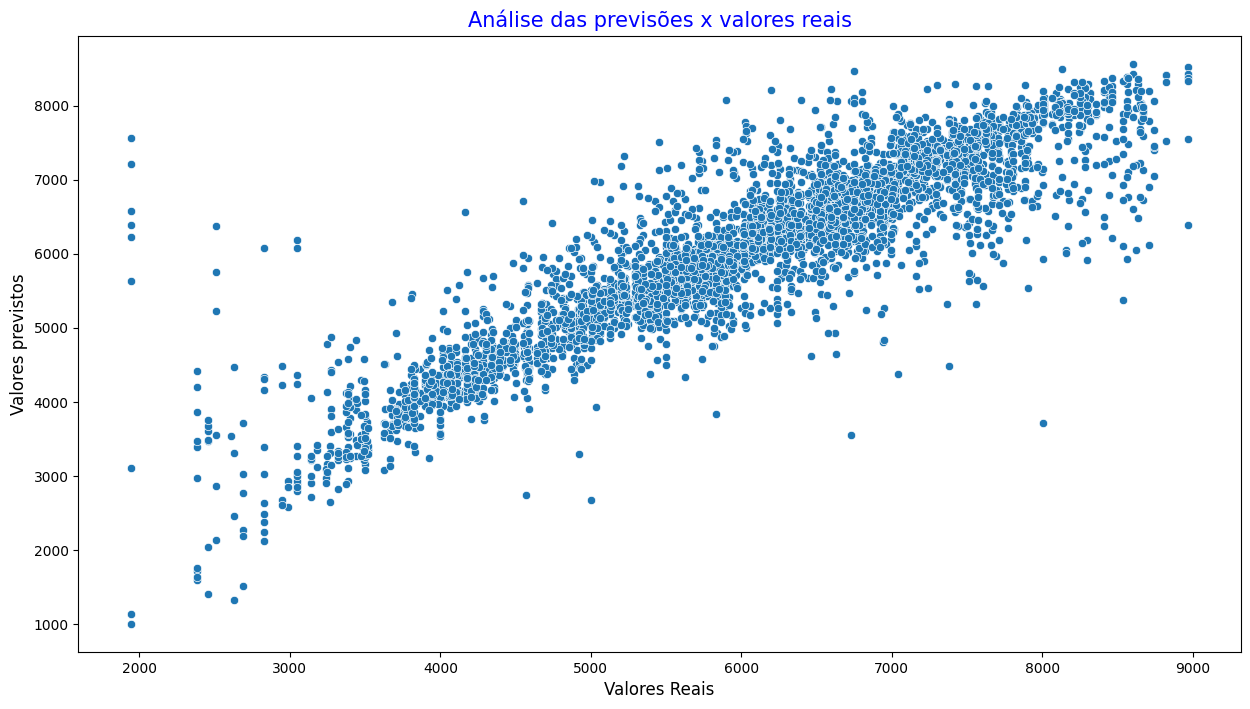

O ERRO OBTIDO PARA ESSA MODELAGEM: 372.69441744469486


In [14]:
X = df_train[['clonesize', 'RainingDays', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds']]
y = df_train[['yield']]

# Transformação de Box Cox
boxcox_transformer = PowerTransformer(method='box-cox')
# Reshape y para uma matriz bidimensional
y_reshaped = np.array(y['yield']).reshape(-1, 1)

y_boxcox = boxcox_transformer.fit_transform(y_reshaped)

y['yield'] = y_boxcox.flatten()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)


OLS = LinearRegression()
OLS = OLS.fit(X_train, y_train)
y_pred = OLS.predict(X_test).squeeze().tolist()


# Convertendo listas para arrays NumPy
y_pred = np.array(y_pred)
y_test = np.array(y_test['yield'])

# Remodelar para uma matriz bidimensional
y_pred = y_pred.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

y_pred_corrigido = boxcox_transformer.inverse_transform(y_pred)
y_test_corrigido = boxcox_transformer.inverse_transform(y_test)

# Verificar se há valores NaN nos dados
#if np.isnan(y_pred_corrigido).any() or np.isnan(y_test_corrigido).any():
#    print("Os dados contêm valores NaN. Ignorando esta divisão.")
#    continue

MAE = mean_absolute_error(y_true=y_test_corrigido, y_pred=y_pred_corrigido)



plt.figure(figsize=(15,8))
sns.scatterplot(x=y_test_corrigido.squeeze().tolist(), y=y_pred_corrigido.squeeze().tolist())
plt.title('Análise das previsões x valores reais', fontsize=15, color='blue')
plt.xlabel('Valores Reais', fontsize=12)
plt.ylabel('Valores previstos', fontsize=12)
plt.show()

print(f'O ERRO OBTIDO PARA ESSA MODELAGEM: {MAE}')

## LGBM REGRESSOR

### SEM TRANSFORMAÇÃO

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 784
[LightGBM] [Info] Number of data points in the train set: 12231, number of used features: 6
[LightGBM] [Info] Start training from score 6021.389860
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 784
[LightGBM] [Info] Number of data points in the train set: 12231, number of used features: 6
[LightGBM] [Info] Start training from score 6026.077178
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 783
[LightGBM] [Info] Number of data points in the train se

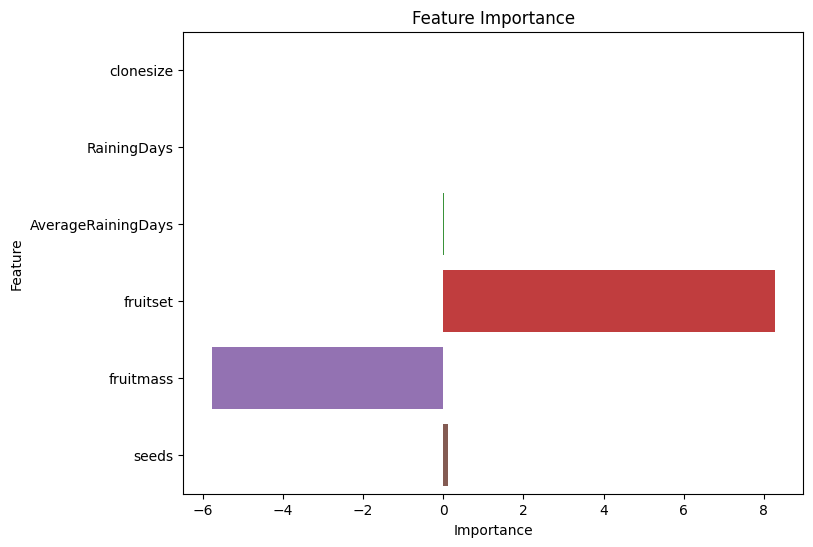

In [15]:
X = df_train[['clonesize', 'RainingDays', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds']]
y = df_train[['yield']]

kf = KFold(n_splits=5, shuffle=True, random_state=10)
MAE_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    lgbm_model = LGBMRegressor(random_state=10)
    lgbm_model.fit(X_train, y_train)
    y_pred = lgbm_model.predict(X_test)

    MAE = mean_absolute_error(y_true=y_test['yield'], y_pred=y_pred)
    MAE_scores.append(MAE)


# Exibir a média e o desvio padrão dos scores de MAE
print(f'Média dos scores de MAE: {np.mean(MAE_scores)}')
print(f'Desvio padrão dos scores de MAE: {np.std(MAE_scores)}')

# Coeficientes do modelo (feature importance) e nomes das features
feature_importance = OLS.coef_[0]
feature_names = X.columns  # Substitua pelos nomes reais das suas features

# Criar um DataFrame para facilitar a plotagem
df_importance = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Plotar a importância dos recursos
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=df_importance, orient='h')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

lista_modelo_utilizado.append('LGBM REGRESSOR')
lista_transformacao_utilizado.append('SEM TRANSFORMAÇÃO')
#lista_num_features.append(len(feature_names))
lista_MAE.append(np.mean(MAE_scores))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 784
[LightGBM] [Info] Number of data points in the train set: 10702, number of used features: 6
[LightGBM] [Info] Start training from score 6021.311876


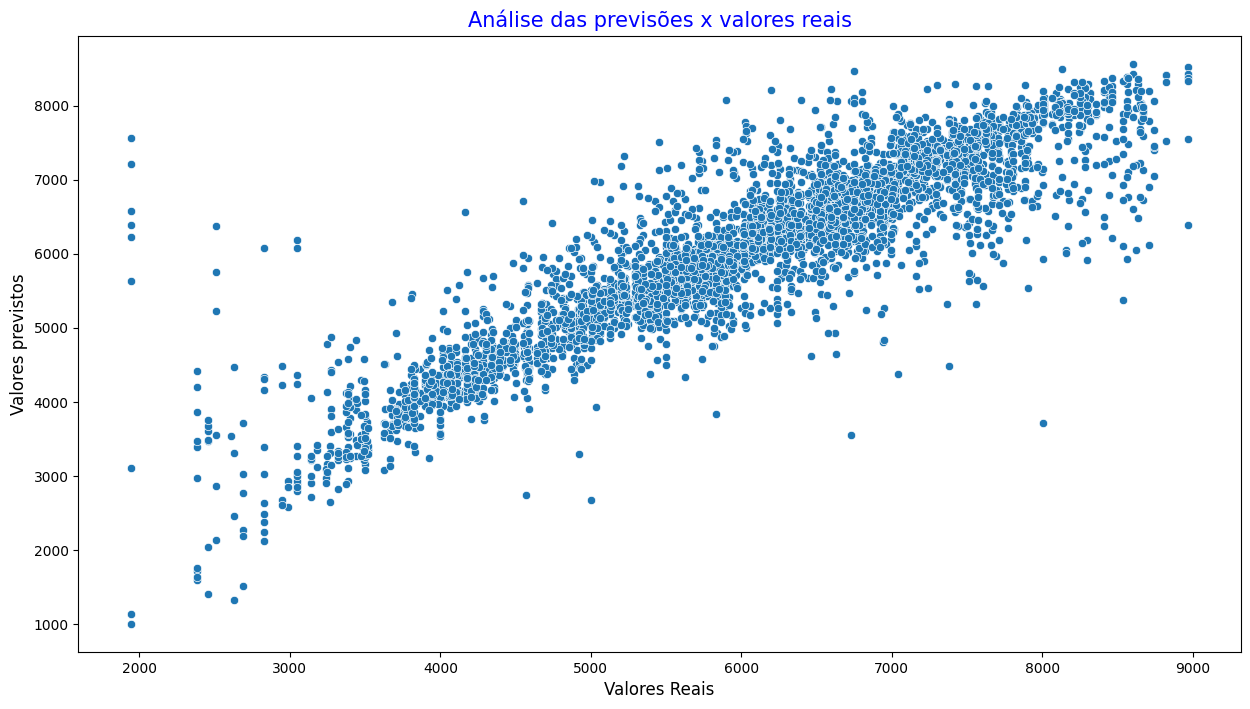

O ERRO OBTIDO PARA ESSA MODELAGEM: 354.3652072121477


In [16]:
X = df_train[['clonesize', 'RainingDays', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds']]
y = df_train[['yield']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

lgbm_model = LGBMRegressor(random_state=10)
lgbm_model.fit(X_train, y_train)
y_pred = lgbm_model.predict(X_test).squeeze().tolist()



MAE = mean_absolute_error(y_true=y_test['yield'], y_pred=y_pred)



plt.figure(figsize=(15,8))
sns.scatterplot(x=y_test_corrigido.squeeze().tolist(), y=y_pred_corrigido.squeeze().tolist())
plt.title('Análise das previsões x valores reais', fontsize=15, color='blue')
plt.xlabel('Valores Reais', fontsize=12)
plt.ylabel('Valores previstos', fontsize=12)
plt.show()

print(f'O ERRO OBTIDO PARA ESSA MODELAGEM: {MAE}')

### BOX-COX

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 784
[LightGBM] [Info] Number of data points in the train set: 12231, number of used features: 6
[LightGBM] [Info] Start training from score -0.002643
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 784
[LightGBM] [Info] Number of data points in the train set: 12231, number of used features: 6
[LightGBM] [Info] Start training from score 0.000596
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 783
[LightGBM] [Info] Number of data points in the train set: 12

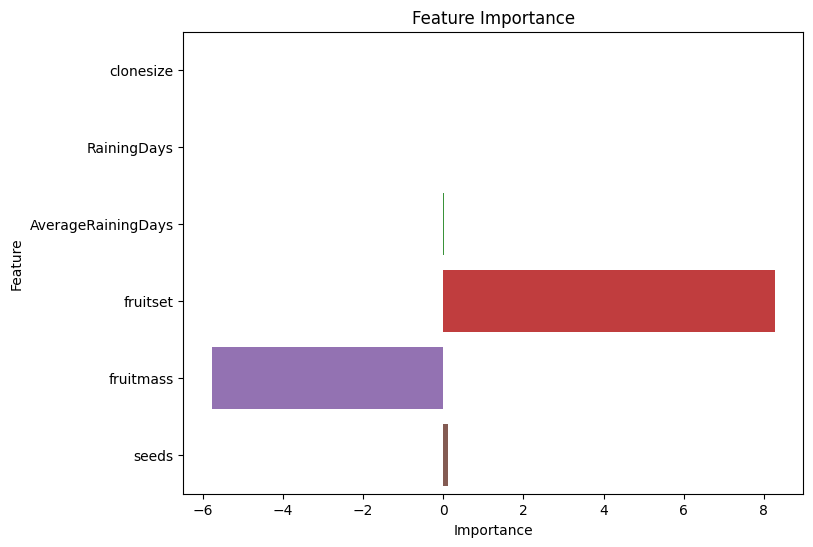

In [17]:
X = df_train[['clonesize', 'RainingDays', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds']]
y = df_train[['yield']]

# Transformação de Box Cox
boxcox_transformer = PowerTransformer(method='box-cox')
# Reshape y para uma matriz bidimensional
y_reshaped = np.array(y['yield']).reshape(-1, 1)

y_boxcox = boxcox_transformer.fit_transform(y_reshaped)

y['yield'] = y_boxcox.flatten()


kf = KFold(n_splits=5, shuffle=True, random_state=10)
MAE_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    lgbm_model = LGBMRegressor(random_state=10)
    lgbm_model.fit(X_train, y_train)
    y_pred = lgbm_model.predict(X_test)

    # Convertendo listas para arrays NumPy
    y_pred = np.array(y_pred)
    y_test = np.array(y_test['yield'])

    # Remodelar para uma matriz bidimensional
    y_pred = y_pred.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    y_pred_corrigido = boxcox_transformer.inverse_transform(y_pred)
    y_test_corrigido = boxcox_transformer.inverse_transform(y_test)



    MAE = mean_absolute_error(y_true=y_test_corrigido, y_pred=y_pred_corrigido)
    MAE_scores.append(MAE)


# Exibir a média e o desvio padrão dos scores de MAE
print(f'Média dos scores de MAE: {np.mean(MAE_scores)}')
print(f'Desvio padrão dos scores de MAE: {np.std(MAE_scores)}')

# Coeficientes do modelo (feature importance) e nomes das features
feature_importance = OLS.coef_[0]
feature_names = X.columns  # Substitua pelos nomes reais das suas features

# Criar um DataFrame para facilitar a plotagem
df_importance = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Plotar a importância dos recursos
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=df_importance, orient='h')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

lista_modelo_utilizado.append('LGBM REGRESSOR')
lista_transformacao_utilizado.append('BOX-COX')
#lista_num_features.append(len(feature_names))
lista_MAE.append(np.mean(MAE_scores))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[LightGBM] [Info] Total Bins 784
[LightGBM] [Info] Number of data points in the train set: 10702, number of used features: 6
[LightGBM] [Info] Start training from score -0.003004


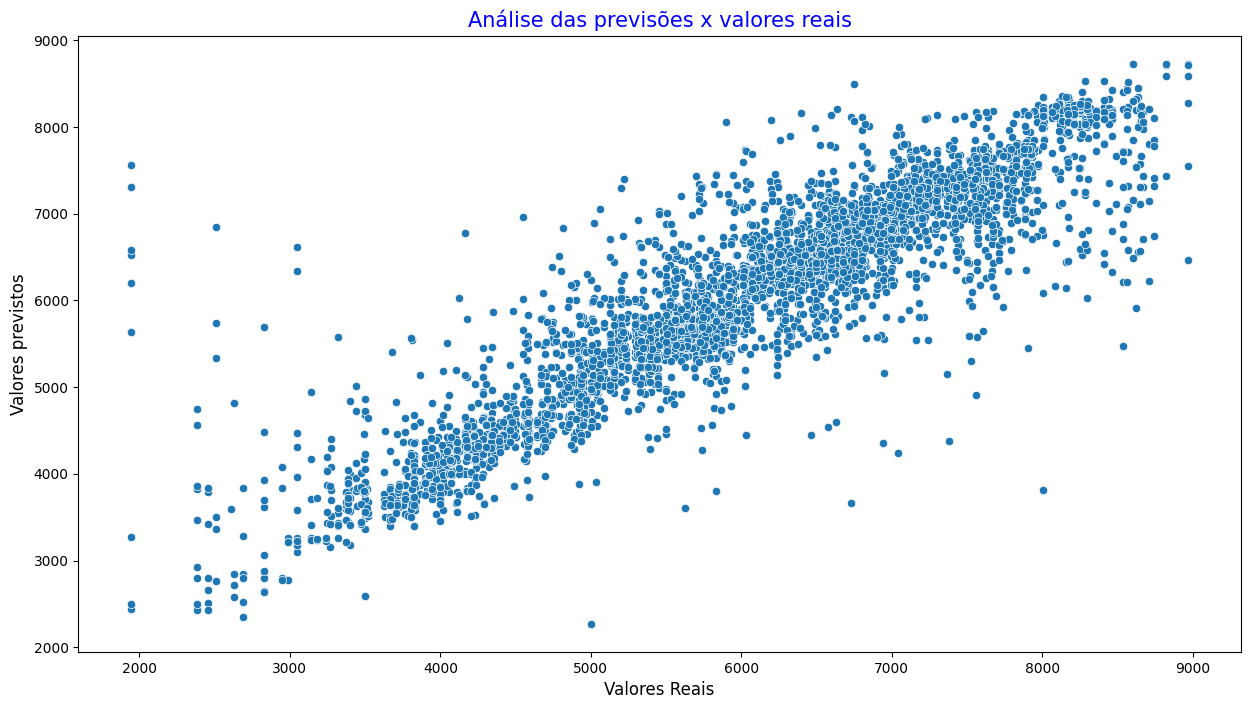

O ERRO OBTIDO PARA ESSA MODELAGEM: 355.33136840892286


In [18]:
X = df_train[['clonesize', 'RainingDays', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds']]
y = df_train[['yield']]

# Transformação de Box Cox
boxcox_transformer = PowerTransformer(method='box-cox')
# Reshape y para uma matriz bidimensional
y_reshaped = np.array(y['yield']).reshape(-1, 1)

y_boxcox = boxcox_transformer.fit_transform(y_reshaped)

y['yield'] = y_boxcox.flatten()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)


lgbm_model = LGBMRegressor(random_state=10)
lgbm_model.fit(X_train, y_train)
y_pred = lgbm_model.predict(X_test).squeeze().tolist()



# Convertendo listas para arrays NumPy
y_pred = np.array(y_pred)
y_test = np.array(y_test['yield'])

# Remodelar para uma matriz bidimensional
y_pred = y_pred.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

y_pred_corrigido = boxcox_transformer.inverse_transform(y_pred)
y_test_corrigido = boxcox_transformer.inverse_transform(y_test)

# Verificar se há valores NaN nos dados
#if np.isnan(y_pred_corrigido).any() or np.isnan(y_test_corrigido).any():
#    print("Os dados contêm valores NaN. Ignorando esta divisão.")
#    continue

MAE = mean_absolute_error(y_true=y_test_corrigido, y_pred=y_pred_corrigido)



plt.figure(figsize=(15,8))
sns.scatterplot(x=y_test_corrigido.squeeze().tolist(), y=y_pred_corrigido.squeeze().tolist())
plt.title('Análise das previsões x valores reais', fontsize=15, color='blue')
plt.xlabel('Valores Reais', fontsize=12)
plt.ylabel('Valores previstos', fontsize=12)
plt.show()

print(f'O ERRO OBTIDO PARA ESSA MODELAGEM: {MAE}')

# Resultados

In [19]:
resultados_modelos = pd.DataFrame({
    'MODELOS': lista_modelo_utilizado,
    'TRANSFORMAÇÃO':lista_transformacao_utilizado,
#    'NUM_FEATURES':lista_num_features,
    'MAE':lista_MAE})

resultados_modelos.sort_values(by='MAE')

,MODELOS,TRANSFORMAÇÃO,MAE
2,LGBM REGRESSOR,SEM TRANSFORMAÇÃO,357.014904
3,LGBM REGRESSOR,BOX-COX,358.039796
0,OLS,SEM TRANSFORMAÇÃO,372.570830
1,OLS,BOX-COX,379.253796


Vamos seguir com as duas transformações e com o modelo de LGBM REGRESSOR
